Before you turn this lab in, make sure everything runs as expected. **Restart and run all cells** (in the menubar, select Kernel$\rightarrow$Restart & Run All) then check the output is as expected and there are no errors.  Also remember to **Save** before uploading this file (File$\rightarrow$Save and Checkpoint).

---

# <div align="center">Quantum Computer Systems Design</div>&nbsp;  <div align="center">Lab 4</div>

In the videos, you saw the steps to compile and optimize a quantum algorithm.  For this lab, you will start with a small circuit, the Cuccaro adder.  This by itself is not a quantum algorithm but can be used as a component in algorithms.  The Cuccaro adder takes as input two quantum registers, a carry-in qubit, and a carry-out qubit and as output overwrites one of the registers and the carry-out bit with the sum.

In part 1, you will decompose the circuit with and without an added control qubit and in part 2, you will consider ancilla.  There is a lot of code in this notebook but you can write no or very little code to solve each problem.  Alternatively, you may use Qiskit to automatially solve each question.

# 1. Quantum Circuit Decomposition

Below is the definition of the Cuccaro adder within Qiskit.  Run each of the below cells untill you reach question 1.1 to start.

In [1]:
import numpy as np
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.circuit.quantumregister import Qubit
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity, random_unitary
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit import BasicAer
backend = BasicAer.get_backend('qasm_simulator')
from IPython.display import display

MAJ:


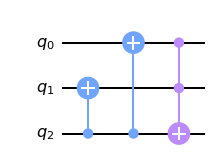

UMA2:


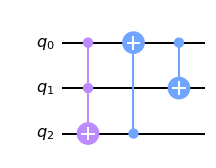

UMA3:


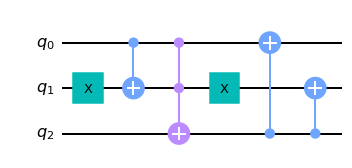

Cuccaro Adder:


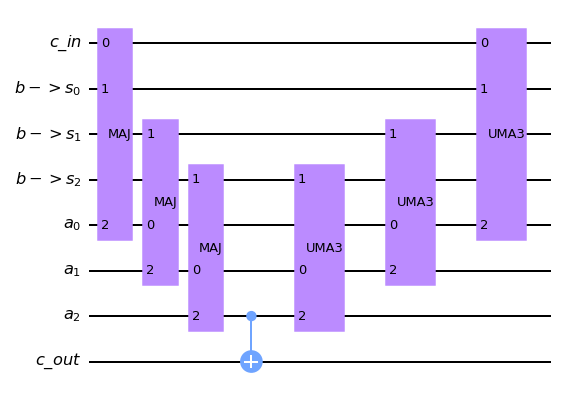

In [2]:
# Implementation of the Cuccaro Quantum Adder from
#   https://github.com/jmbaker94/quantumcircuitbenchmarks
# Design from the paper
#   https://arxiv.org/abs/quant-ph/0410184

# Majority gate
maj_c = QuantumCircuit(3, name='MAJ')
maj_c.cx(2, 1)
maj_c.cx(2, 0)
maj_c.ccx(0, 1, 2)
maj = maj_c.to_gate(label='MAJ')
print('MAJ:')
display(maj_c.draw(fold=-1))

# 2-CNOT version of UnMajority and Add gate
uma2_c = QuantumCircuit(3, name='UMA2')
uma2_c.toffoli(0, 1, 2)
uma2_c.cx(2, 0)
uma2_c.cx(0, 1)
uma2 = uma2_c.to_gate(label='UMA2')
print('UMA2:')
display(uma2_c.draw(fold=-1))

# 3-CNOT version of UnMajority and Add gate
# (Allows more parallelism in the circuit)
uma3_c = QuantumCircuit(3, name='UMA3')
uma3_c.x(1)
uma3_c.cx(0, 1)
uma3_c.toffoli(0, 1, 2)
uma3_c.x(1)
uma3_c.cx(2, 0)
uma3_c.cx(2, 1)
uma3 = uma3_c.to_gate(label='UMA3')
print('UMA3:')
display(uma3_c.draw(fold=-1))

def cuccaro_adder(c, cin, a, b, cout, uma=uma3):
    c.append(maj, [cin, b[0], a[0]])
    for i in range(1, len(b)):
        c.append(maj, [a[i-1], b[i], a[i]])

    c.cx(a[-1], cout)

    for i in reversed(range(1, len(b))):
        c.append(uma, [a[i-1], b[i], a[i]])
    c.append(uma, [cin, b[0], a[0]])

def generate_adder_circuit(n, uma=uma3):
    if n % 2 != 0:
        raise ValueError('Odd number of qubits')

    cin = QuantumRegister(1, 'c_in')
    a = QuantumRegister(n//2-1, 'a')
    b = QuantumRegister(n//2-1, 'b->s')
    cout = QuantumRegister(1, 'c_out')
    c = QuantumCircuit(cin, b, a, cout)
        
    cuccaro_adder(c, cin, a, b, cout, uma=uma)
    return c

print('Cuccaro Adder:')
cuccaro8 = generate_adder_circuit(8)
cuccaro8.draw(fold=-1)

In [3]:
# Export to QASM
print(cuccaro8.qasm())

OPENQASM 2.0;
include "qelib1.inc";
gate gate_MAJ q0,q1,q2 { cx q2,q1; cx q2,q0; ccx q0,q1,q2; }
gate gate_UMA3 q0,q1,q2 { x q1; cx q0,q1; ccx q0,q1,q2; x q1; cx q2,q0; cx q2,q1; }
qreg c_in[1];
qreg b->s[3];
qreg a[3];
qreg c_out[1];
gate_MAJ c_in[0],b->s[0],a[0];
gate_MAJ a[0],b->s[1],a[1];
gate_MAJ a[1],b->s[2],a[2];
cx a[2],c_out[0];
gate_UMA3 a[1],b->s[2],a[2];
gate_UMA3 a[0],b->s[1],a[1];
gate_UMA3 c_in[0],b->s[0],a[0];



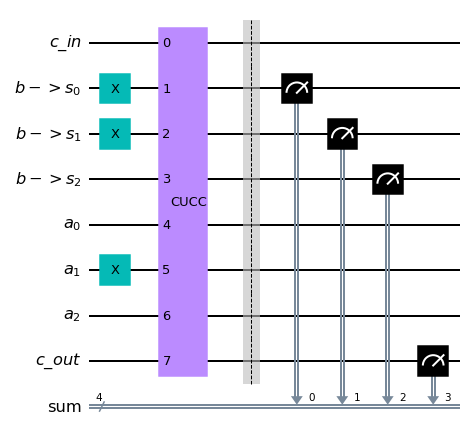

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


{'0101': 128}

In [4]:
# Try it out!
n = 8
cin = QuantumRegister(1, 'c_in')
a = QuantumRegister(n//2-1, 'a')
b = QuantumRegister(n//2-1, 'b->s')
cout = QuantumRegister(1, 'c_out')
creg = ClassicalRegister(n//2, 'sum')
c = QuantumCircuit(cin, b, a, cout, creg)

# Test on a specific input
# carry-in=0 CHANGE ME!
###c.x(cin[0])

# a=2 (0b010) CHANGE ME!
###c.x(a[0])
c.x(a[1])
###c.x(a[2])

# b=3 (0b011) CHANGE ME!
c.x(b[0])
c.x(b[1])
###c.x(b[2])

#cuccaro_adder(c, cin, a, b, cout)
c.append(cuccaro8.to_gate(label='CUCC'), [*cin, *b, *a, *cout])

# Measure the result
c.barrier()
c.measure([*b, *cout], creg)

# Show the circuit
display(c.draw(fold=-1))

# Simulate the result
# 0 + 2 + 3 = 5 (0b0101)
execute(c, backend, shots=128).result().get_counts(c)

## 1.1. CNOT and Toffoli

Decompose the below adder circuit into single-qubit, CNOT, and Toffoli gates (by hand or with code).  **How many of each gate are used in the resulting circuit?**

If you choose to use Qiskit, check out `qiskit.transpiler.PassManager` and `qiskit.transpiler.passes.Unroller`.  Inspect the gates in a circuit with `list(circuit)`.

Cuccaro Adder:


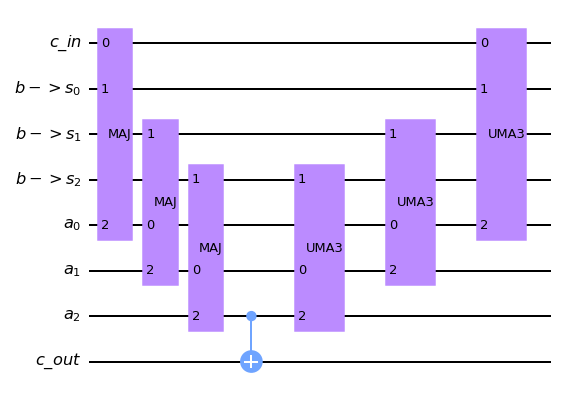

In [5]:
print('Cuccaro Adder:')
cuccaro8 = generate_adder_circuit(8)
cuccaro8.draw(fold=-1)

In [6]:
print(list(cuccaro8))

[(Instruction(name='MAJ', num_qubits=3, num_clbits=0, params=[]), [Qubit(QuantumRegister(1, 'c_in'), 0), Qubit(QuantumRegister(3, 'b->s'), 0), Qubit(QuantumRegister(3, 'a'), 0)], []), (Instruction(name='MAJ', num_qubits=3, num_clbits=0, params=[]), [Qubit(QuantumRegister(3, 'a'), 0), Qubit(QuantumRegister(3, 'b->s'), 1), Qubit(QuantumRegister(3, 'a'), 1)], []), (Instruction(name='MAJ', num_qubits=3, num_clbits=0, params=[]), [Qubit(QuantumRegister(3, 'a'), 1), Qubit(QuantumRegister(3, 'b->s'), 2), Qubit(QuantumRegister(3, 'a'), 2)], []), (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), [Qubit(QuantumRegister(3, 'a'), 2), Qubit(QuantumRegister(1, 'c_out'), 0)], []), (Instruction(name='UMA3', num_qubits=3, num_clbits=0, params=[]), [Qubit(QuantumRegister(3, 'a'), 1), Qubit(QuantumRegister(3, 'b->s'), 2), Qubit(QuantumRegister(3, 'a'), 2)], []), (Instruction(name='UMA3', num_qubits=3, num_clbits=0, params=[]), [Qubit(QuantumRegister(3, 'a'), 0), Qubit(QuantumRegister(3, 'b-

In [7]:
# Give your counts here
count_x_1 = 6
count_cnot_1 = 16
count_toffoli_1 = 6
# YOUR CODE HERE


print(f'{count_x_1} single-qubit (X), {count_cnot_1} CNOT, '
      f'and {count_toffoli_1} Toffoli gates')

6 single-qubit (X), 16 CNOT, and 6 Toffoli gates


In [8]:
# Do not delete this cell
# The autograder will test the value stored in `count_x_1`.
assert 0 <= count_x_1 <= 100, 'count_x_1 must be an integer in this range'
# Rejects most incorrect answers without giving away the correct answer
assert count_x_1 % 5 == 1, 'Incorrect answer'
# Hidden test
print('PASS')

PASS


In [9]:
# Do not delete this cell
# The autograder will test the value stored in `count_cnot_1`.
assert 0 <= count_cnot_1 <= 100, 'count_cnot_1 must be an integer in this range'
# Rejects most incorrect answers without giving away the correct answer
assert count_cnot_1 % 5 == 1, 'Incorrect answer'
# Hidden test
print('PASS')

PASS


In [10]:
# Do not delete this cell
# The autograder will test the value stored in `count_toffoli_1`.
assert 0 <= count_toffoli_1 <= 100, 'count_toffoli_1 must be an integer in this range'
# Rejects most incorrect answers without giving away the correct answer
assert count_toffoli_1 % 5 == 1, 'Incorrect answer'
# Hidden test
print('PASS')

PASS


## 1.2. CNOT Only

Toffoli gates are typically further decomposed into single-qubit and CNOT gates as shown below.  Decompose the same adder circuit from the previous question into only single-qubit and CNOT gates (by hand or with code).  **How many of each gate are used in the resulting circuit?**

Qiskit always uses the 6-CNOT decomposition but for these questions, **use the 8-CNOT Toffoli decomposition**.

Toffoli (6 CNOT decomposition):


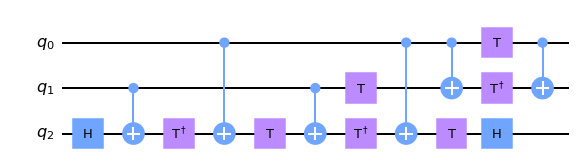

In [11]:
# Popular Toffoli decomposition
# Do not use for this question
toffoli6cx_c = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[3];\nh q[2];\ncx q[1],q[2];\ntdg q[2];\ncx q[0],q[2];\nt q[2];\ncx q[1],q[2];\ntdg q[2];\ncx q[0],q[2];\nt q[1];\nt q[2];\ncx q[0],q[1];\nt q[0];\ntdg q[1];\nh q[2];\ncx q[0],q[1];\n')
print('Toffoli (6 CNOT decomposition):')
toffoli6cx_c.draw(fold=-1)

Toffoli (8 CNOT decomposition):


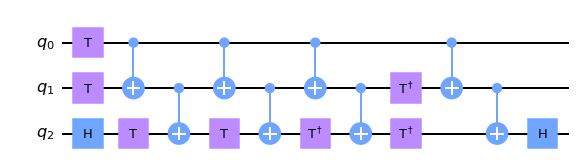

In [12]:
# An alternative Toffoli decomposition
toffoli8cx_c = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[3];\nh q[2];\nt q[0];\nt q[1];\nt q[2];\ncx q[0],q[1];\ncx q[1],q[2];\nt q[2];\ncx q[0],q[1];\ncx q[1],q[2];\ntdg q[2];\ncx q[0],q[1];\ncx q[1],q[2];\ntdg q[1];\ntdg q[2];\ncx q[0],q[1];\ncx q[1],q[2];\nh q[2];\n')
print('Toffoli (8 CNOT decomposition):')
toffoli8cx_c.draw(fold=-1)

In [13]:
# Scratch space

In [14]:
# Give your counts for X, H, (T and T dagger), and CNOT here
count_x_2 = count_x_1
count_hadamard_2 = 12
count_t_and_tdag_2 = 42
count_cnot_2 = count_cnot_1 + (8 * count_toffoli_1)
# YOUR CODE HERE
# count_cnot_1 = 16
# count_toffoli_1 = 6

print(f'{count_x_2} X, {count_hadamard_2} Hadamard, '
      f'{count_t_and_tdag_2} T and inverse-T, '
      f'{count_cnot_2} CNOT, and no Toffoli gates')

6 X, 12 Hadamard, 42 T and inverse-T, 64 CNOT, and no Toffoli gates


In [15]:
# Do not delete this cell
# The autograder will test the value stored in `count_hadamard_2`.
assert 0 <= count_hadamard_2 <= 100, 'count_hadamard_2 must be an integer in this range'
# Rejects most incorrect answers without giving away the correct answer
assert count_hadamard_2 % 10 == 2, 'Incorrect answer'
# Hidden test
print('PASS')

PASS


In [16]:
# Do not delete this cell
# The autograder will test the value stored in `count_t_and_tdag_2`.
assert 0 <= count_t_and_tdag_2 <= 100, 'count_t_and_tdag_2 must be an integer in this range'
# Rejects most incorrect answers without giving away the correct answer
assert count_t_and_tdag_2 % 10 == 2, 'Incorrect answer'
# Hidden test
print('PASS')

PASS


In [17]:
# Do not delete this cell
# The autograder will test the value stored in `count_cnot_2`.
assert 0 <= count_cnot_2 <= 100, 'count_cnot_2 must be an integer in this range'
# Rejects most incorrect answers without giving away the correct answer
assert count_cnot_2 % 10 == 4, 'Incorrect answer'
# Hidden test
print('PASS')

PASS


## 1.3. Controlled Circuit

Some applications of an adder circuit require that it execute and not execute in superposition.  That is, when a control qubit is $|1\rangle$, take $|a, b\rangle\rightarrow|a, a+b\rangle$ but when the control qubit is $|0\rangle$, take $|a, b\rangle\rightarrow|a, b\rangle$.
This construction can also be used to build a multiplier out of adders.

A simple (but not the most efficient) method to decompose a circuit with an added control qubit is to *distribute* that control to each gate of the original decomposition.  In the previous question, you generated a circuit containing only CNOT, X, H, T, and T$^\dagger$ gates.  By adding a control to each, you get a circuit containing Toffoli, CNOT, controlled-H, controlled-T, and controlled-T$^\dagger$ gates.

When you fully decompose this 8-qubit controlled-Cuccaro adder into only CNOT and single-qubit gates, **how many total CNOT gates are used?**  (Don't bother counting the single-qubit gates this time.)  The decompositions for controlled-H and controlled-T are given below.  Use the 8-CNOT Toffoli decomposition again.

You may want to use the variables `count_x_2`, `count_hadamard_2`, `count_t_and_tdag_2`, `count_cnot_2`.  The variables `cnots_per_controlled_h` and `cnots_per_controlled_t_and_tdag` given below may also be useful.

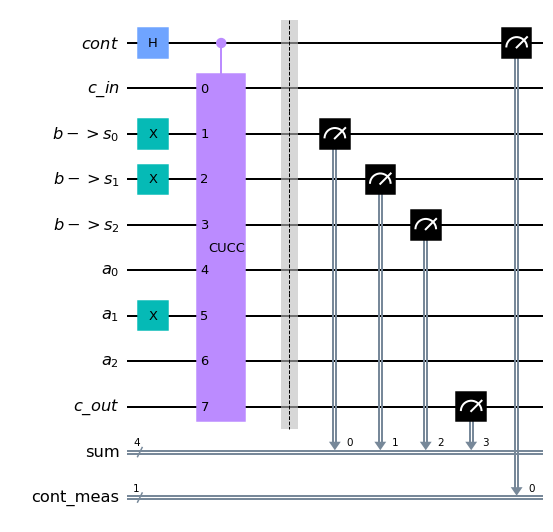

{'1 0101': 56, '0 0011': 72}

In [18]:
# Try it out!
n = 8
control = QuantumRegister(1, 'cont')
cin = QuantumRegister(1, 'c_in')
a = QuantumRegister(n//2-1, 'a')
b = QuantumRegister(n//2-1, 'b->s')
cout = QuantumRegister(1, 'c_out')
creg = ClassicalRegister(n//2, 'sum')
creg2 = ClassicalRegister(1, 'cont_meas')
controlled_demo = QuantumCircuit(control, cin, b, a, cout, creg, creg2)

# Test on a specific input
# carry-in=0 CHANGE ME!
###controlled_demo.x(cin[0])

# a=2 (0b010) CHANGE ME!
###controlled_demo.x(a[0])
controlled_demo.x(a[1])
###controlled_demo.x(a[2])

# b=3 (0b011) CHANGE ME!
controlled_demo.x(b[0])
controlled_demo.x(b[1])
###controlled_demo.x(b[2])

controlled_demo.h(control)

cuccaro8 = generate_adder_circuit(8)
controlled_demo.append(cuccaro8.to_gate(label='CUCC').control(1),
                       [control[0], *cin, *b, *a, *cout])

# Measure the result
controlled_demo.barrier()
controlled_demo.measure([*b, *cout], creg)
controlled_demo.measure(control, creg2)

# Show the circuit
display(controlled_demo.draw(fold=-1))

# Simulate the result
# 0 + 2 + 3 = 5 (0b0101) if control=1
# 3 = 3 (0b0011) if control = 0
execute(controlled_demo, backend, shots=128).result(
        ).get_counts(controlled_demo)

Controlled-H gate from CNOTs:


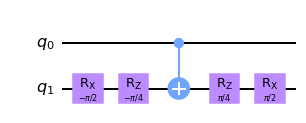

In [19]:
# Example decomposition of the controlled-H gate
c = QuantumCircuit(2)
c.ch(0, 1)
print('Controlled-H gate from CNOTs:')
display(
    qiskit.transpile(c, basis_gates=['rz', 'rx', 'cx'])
    .draw(fold=-1))

cnots_per_controlled_h = 1

Controlled-T gate from CNOTs:


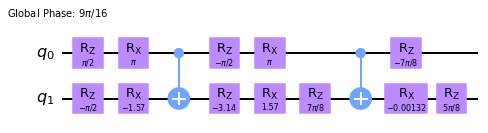

In [20]:
# Example decomposition of the controlled-T gate
c = QuantumCircuit(2)
# Unitary of the controlled-T gate
c.append(qiskit.quantum_info.Operator(np.diag([
    1, 1, 1, np.exp(1j*np.pi/4)
])), [0, 1])
print('Controlled-T gate from CNOTs:')
display(
    qiskit.transpile(c, basis_gates=['rz', 'rx', 'cx'])
    .draw(fold=-1))

cnots_per_controlled_t_and_tdag = 2

In [21]:
# Give the number of CNOT gates here
count_cnot_3 = (count_hadamard_2 * cnots_per_controlled_h) + (count_t_and_tdag_2 * cnots_per_controlled_t_and_tdag) + count_x_2 + (8 * count_cnot_2)
# YOUR CODE HERE

print(f'Many single-qubit and {count_cnot_3} CNOT gates')

Many single-qubit and 614 CNOT gates


In [22]:
# Do not delete this cell
# The autograder will test the value stored in `count_cnot_3`.
assert 0 <= count_cnot_3 <= 999, 'count_cnot_3 must be an integer in this range'
# Rejects most incorrect answers without giving away the correct answer
assert count_cnot_3 % 10 == 4, 'Incorrect answer'
# Hidden test
print('PASS')

PASS


In [23]:
print('Comparing your answers to 1.2 and 1.3:')
print('Adding one control to the circuit increased the size from '
      f'{count_cnot_2} CNOT gates to {count_cnot_3} CNOT gates '
      '(should be a factor of ~10x).  Is this more than you expected?')

Comparing your answers to 1.2 and 1.3:
Adding one control to the circuit increased the size from 64 CNOT gates to 614 CNOT gates (should be a factor of ~10x).  Is this more than you expected?


Note: It is often better to distribute the control to a few key gates instead of all of them.  If these key gates are chosen right, the effects of the other gates will cancel each other out if the control is 0.

For this 8-qubit Cuccaro adder, this is possible by only adding a control to four of the CNOT gates (and also adding three extra Toffolis).  This gives about a 2x overhead of adding a control instead of the 10x found above.

# 2. Ancilla

In the first part, you decomposed a controlled-adder to CNOT and single-qubit gates.  By using additional workspace qubits (called ancilla), a compiler can produce a circuit with fewer gates and/or more parallelism between gates (therefore shorter runtime).  However, this is only possible if the quantum computer has more qubits than the algorithm to be compiled.

The design of the Cuccaro adder you decomposed in part 1 does not use any ancilla but a compiler may choose to add some in the process of decomposing the circuit.  In this problem, you will decomposed the controlled-Cuccaro adder again, but now with ancilla.

# 2.1. Multi-Controlled Not Gate&nbsp;<h4 style="margin-top:0;margin-left:3.7em">(also called multi-control Toffoli or CnX for short)</h4>

Let's go back to question 1.1 where you decomposed the Cuccaro adder into single-qubit, CNOT, and Toffoli gates.  Here are the gate counts you answered in 1.1 (double check that none of your code modified these variables after problem 1.1):

In [24]:
print('Your answer from problem 1.1:')
print(f'{count_x_1} single-qubit (X), {count_cnot_1} CNOT, '
      f'and {count_toffoli_1} Toffoli gates in the Cuccaro adder '
      '(without a control qubit)')

Your answer from problem 1.1:
6 single-qubit (X), 16 CNOT, and 6 Toffoli gates in the Cuccaro adder (without a control qubit)


In [25]:
# Do not delete this cell
# This just double-checks your answers from problem 1.1 (not worth any points)
assert 0 <= count_x_1 <= 100, 'count_x_1 must be an integer in this range'
assert 0 <= count_cnot_1 <= 100, 'count_cnot_1 must be an integer in this range'
assert 0 <= count_toffoli_1 <= 100, 'count_toffoli_1 must be an integer in this range'
# Rejects most incorrect answers without giving away the correct answer
assert count_x_1 % 5 == 1, 'Incorrect answer'
assert count_cnot_1 % 5 == 1, 'Incorrect answer'
assert count_toffoli_1 % 5 == 1, 'Incorrect answer'
# Hidden tests
print('PASS')

PASS


#### (2.1 continued)

Now, add the control qubit to this decomposition from 1.1.  When you distribute the control to each of the Toffoli, CNOT, and X gates, you will get a circuit containing 3-control NOT (C3X), Toffoli, and CNOT gates respectivly.

After adding the control, finish decomposing this circuit to single-qubit and CNOT gates.  You already know how to decompose Toffoli gates to CNOTs.  In lecture 4b, you saw several possible ways to decompose the C3X gate, both with and without ancilla.  Two of these decompositions are given below.

For this question, count **how many CNOT gates are used by this decomposition**.  Use the 8-CNOT Toffoli decomposition and the one-ancilla C3X decomposition.  Don't bother counting the single-qubit gates.

The circuit you are decomposing:


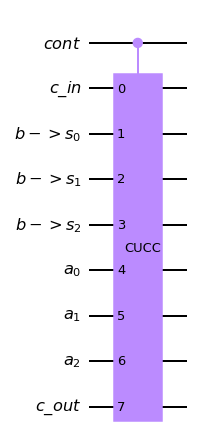

In [26]:
# Show the controlled-Cuccaro adder again
# Decompose this circuit as described
n = 8
control = QuantumRegister(1, 'cont')
cin = QuantumRegister(1, 'c_in')
a = QuantumRegister(n//2-1, 'a')
b = QuantumRegister(n//2-1, 'b->s')
cout = QuantumRegister(1, 'c_out')
controlled_cucc = QuantumCircuit(control, cin, b, a, cout)

cuccaro8 = generate_adder_circuit(8)
controlled_cucc.append(cuccaro8.to_gate(label='CUCC').control(1),
                       [control[0], *cin, *b, *a, *cout])
print('The circuit you are decomposing:')
display(controlled_cucc.draw(fold=-1))

C3X decomposition (no ancilla):


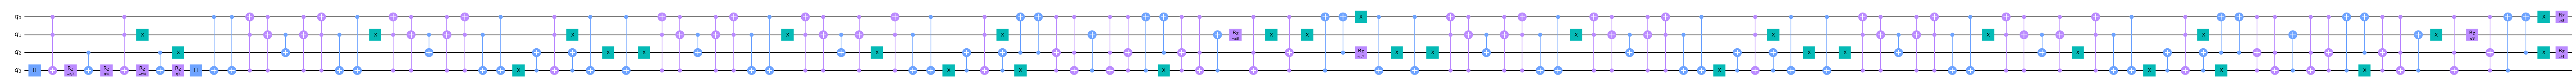

In [27]:
# 3-Control NOT decomposition (without ancilla)
# Do not use for this question
# Circuit from https://github.com/jmbaker94/quantumcircuitbenchmarks/blob/master/quantumcircuitbenchmarks/qiskit/cnx_inplace.py
c3x_0a_c = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\n\n\n// Qubits: [0, 1, 2, 3]\nqreg q[4];\n\n\nh q[3];\nccx q[0],q[1],q[3];\nrz(pi*-0.25) q[3];\ncx q[2],q[3];\nrz(pi*0.25) q[3];\nccx q[0],q[1],q[3];\nrz(pi*-0.25) q[3];\nx q[1];\ncx q[2],q[3];\nrz(pi*0.25) q[3];\nx q[2];\nh q[3];\ncx q[0],q[3];\ncx q[0],q[3];\nccx q[1],q[3],q[0];\nccx q[0],q[3],q[1];\ncx q[1],q[2];\nccx q[0],q[3],q[1];\nccx q[1],q[3],q[0];\ncx q[1],q[3];\nx q[1];\ncx q[0],q[3];\nccx q[1],q[3],q[0];\nccx q[0],q[3],q[1];\ncx q[1],q[2];\nccx q[0],q[3],q[1];\nccx q[1],q[3],q[0];\ncx q[1],q[3];\ncx q[0],q[3];\nx q[3];\ncx q[3],q[2];\nccx q[0],q[1],q[3];\ncx q[3],q[2];\nx q[1];\nx q[2];\ncx q[0],q[3];\nx q[2];\ncx q[0],q[3];\nccx q[1],q[3],q[0];\nccx q[0],q[3],q[1];\ncx q[1],q[2];\nccx q[0],q[3],q[1];\nccx q[1],q[3],q[0];\ncx q[1],q[3];\nx q[1];\ncx q[0],q[3];\nccx q[1],q[3],q[0];\nccx q[0],q[3],q[1];\ncx q[1],q[2];\nccx q[0],q[3],q[1];\nx q[2];\nccx q[1],q[3],q[0];\ncx q[1],q[3];\ncx q[0],q[3];\nx q[3];\ncx q[3],q[2];\nccx q[0],q[1],q[3];\ncx q[3],q[2];\nx q[1];\ncx q[2],q[0];\nx q[3];\ncx q[2],q[0];\nccx q[3],q[0],q[2];\nccx q[2],q[0],q[3];\ncx q[3],q[1];\nccx q[2],q[0],q[3];\nccx q[3],q[0],q[2];\ncx q[3],q[0];\nx q[3];\ncx q[2],q[0];\nccx q[3],q[0],q[2];\nccx q[2],q[0],q[3];\ncx q[3],q[1];\nccx q[2],q[0],q[3];\nrz(pi*-0.125) q[1];\nccx q[3],q[0],q[2];\nx q[1];\ncx q[3],q[0];\nx q[1];\ncx q[2],q[0];\nrz(pi*-0.25) q[2];\nx q[0];\nx q[2];\ncx q[0],q[3];\nx q[2];\ncx q[0],q[3];\nccx q[1],q[3],q[0];\nccx q[0],q[3],q[1];\ncx q[1],q[2];\nccx q[0],q[3],q[1];\nccx q[1],q[3],q[0];\ncx q[1],q[3];\nx q[1];\ncx q[0],q[3];\nccx q[1],q[3],q[0];\nccx q[0],q[3],q[1];\ncx q[1],q[2];\nccx q[0],q[3],q[1];\nccx q[1],q[3],q[0];\ncx q[1],q[3];\ncx q[0],q[3];\nx q[3];\ncx q[3],q[2];\nccx q[0],q[1],q[3];\ncx q[3],q[2];\nx q[1];\nx q[2];\ncx q[0],q[3];\nx q[2];\ncx q[0],q[3];\nccx q[1],q[3],q[0];\nccx q[0],q[3],q[1];\ncx q[1],q[2];\nccx q[0],q[3],q[1];\nccx q[1],q[3],q[0];\ncx q[1],q[3];\nx q[1];\ncx q[0],q[3];\nccx q[1],q[3],q[0];\nccx q[0],q[3],q[1];\ncx q[1],q[2];\nccx q[0],q[3],q[1];\nx q[2];\nccx q[1],q[3],q[0];\ncx q[1],q[3];\ncx q[0],q[3];\nx q[3];\ncx q[3],q[2];\nccx q[0],q[1],q[3];\ncx q[3],q[2];\nx q[1];\ncx q[2],q[0];\nx q[3];\ncx q[2],q[0];\nccx q[3],q[0],q[2];\nccx q[2],q[0],q[3];\ncx q[3],q[1];\nccx q[2],q[0],q[3];\nccx q[3],q[0],q[2];\ncx q[3],q[0];\nx q[3];\ncx q[2],q[0];\nccx q[3],q[0],q[2];\nccx q[2],q[0],q[3];\ncx q[3],q[1];\nccx q[2],q[0],q[3];\nx q[1];\nccx q[3],q[0],q[2];\nrz(pi*0.125) q[1];\ncx q[3],q[0];\ncx q[2],q[0];\nx q[0];\nx q[2];\nrz(pi*0.25) q[2];\nrz(pi*0.125) q[0];\n')
print('C3X decomposition (no ancilla):')
display(c3x_0a_c.draw(fold=-1))

# This is the unitary matrix for C3X (a 4-qubit gate)
# The value is an idententy matrix except for the entries
# corresponding to |1110> and |1111>.
c3x_0a_unitary = qiskit.quantum_info.Operator(c3x_0a_c).data

C3X decomposition (one ancilla):


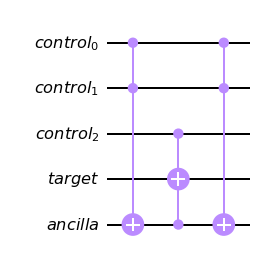

In [28]:
# 3-Control NOT decomposition (with one ancilla)
controls = QuantumRegister(3, 'control')
target = QuantumRegister(1, 'target')
ancilla = QuantumRegister(1, 'ancilla')
c3x_1a_c = QuantumCircuit(controls, target, ancilla)
c3x_1a_c.ccx(controls[0], controls[1], ancilla[0])
c3x_1a_c.ccx(controls[2], ancilla[0], target[0])
c3x_1a_c.ccx(controls[0], controls[1], ancilla[0])
print('C3X decomposition (one ancilla):')
display(c3x_1a_c.draw(fold=-1))

# This is the unitary matrix for C3X (a 4-qubit gate)
# The value is an idententy matrix except for the entries
# corresponding to |11100> and |11110>.
# Ignore the entries |xxxx1> where the ancilla is initially a 1.
c3x_1a_unitary = qiskit.quantum_info.Operator(c3x_1a_c).data

toffolis_per_c3x = 3

Toffoli (8 CNOT decomposition):


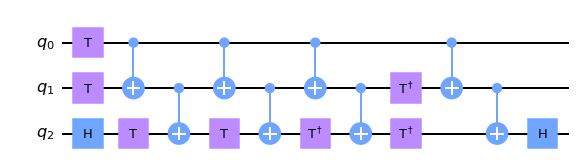

In [29]:
# The 8-CNOT Toffoli decomposition (again)
toffoli8cx_c = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[3];\nh q[2];\nt q[0];\nt q[1];\nt q[2];\ncx q[0],q[1];\ncx q[1],q[2];\nt q[2];\ncx q[0],q[1];\ncx q[1],q[2];\ntdg q[2];\ncx q[0],q[1];\ncx q[1],q[2];\ntdg q[1];\ntdg q[2];\ncx q[0],q[1];\ncx q[1],q[2];\nh q[2];\n')
print('Toffoli (8 CNOT decomposition):')
display(toffoli8cx_c.draw(fold=-1))

cnots_per_toffoli = 8

In [30]:
# Intermediate calculation for your answer
cnots_per_c3x = toffolis_per_c3x * cnots_per_toffoli

In [31]:
print('Your answer from problem 1.1 again:')
print(f'{count_x_1} single-qubit (X), {count_cnot_1} CNOT, '
      f'and {count_toffoli_1} Toffoli gates in the Cuccaro adder '
      '(without a control qubit)')

Your answer from problem 1.1 again:
6 single-qubit (X), 16 CNOT, and 6 Toffoli gates in the Cuccaro adder (without a control qubit)


In [32]:
# Answer the number of CNOT gates here
count_cnot_4 = count_x_1 + (count_cnot_1 * cnots_per_toffoli) + (count_toffoli_1 * cnots_per_c3x)
# YOUR CODE HERE
# print(f'{count_x_1} single-qubit (X), {count_cnot_1} CNOT, '
#       f'and {count_toffoli_1} Toffoli gates in the Cuccaro adder '
#       '(without a control qubit)')

print(f'Many single-qubit and {count_cnot_4} CNOT gates')

Many single-qubit and 278 CNOT gates


In [33]:
# Do not delete this cell
# The autograder will test the value stored in `count_cnot_4`.
assert 0 <= count_cnot_4 <= 999, 'count_cnot_4 must be an integer in this range'
# Rejects most incorrect answers without giving away the correct answer
assert count_cnot_4 % 46 == 2, 'Incorrect answer'
# Hidden test
print('PASS')

PASS


# 2.2. Multi-Controlled Not Gate (continue)

How many ancilla did you use in that last decomposition (problem 2.1)?  Each C3X gate needs one ancilla but they can share ancilla if one C3X gate is finished before another C3X gate starts.  Count the maximum and minimum possible number of ancilla a compiler could choose to use.  Assume the compiler only knows the decomposition shown above that contains 6 C3X gates.  The min and max will depend on how the compiler schedules the gates to share resources.

In [34]:
# For problem 2.2, assume 6 C3X gates were used
count_c3x_5 = 6

# Enter the *minimum* number of ancilla that could be used
count_ancilla_min_5 = 1
# YOUR CODE HERE

# Enter the *maximum* number of ancilla that could be used
count_ancilla_max_5 = count_toffoli_1
# YOUR CODE HERE

print('The number of ancilla used is: '
      f'{count_ancilla_min_5} <= n <= {count_ancilla_max_5}')
print('The total number of qubits used is: '
      f'{8+count_ancilla_min_5} <= n <= {8+count_ancilla_max_5}')

The number of ancilla used is: 1 <= n <= 6
The total number of qubits used is: 9 <= n <= 14


In [35]:
# Do not delete this cell
# The autograder will test the value stored in `count_ancilla_min_5`.
assert 0 <= count_ancilla_min_5 <= 20, 'count_ancilla_min_5 must be an integer in this range'
assert count_ancilla_min_5 <= count_ancilla_max_5, 'min must be <= max'
print('PASS')

PASS


In [36]:
## Do not delete this cell
# The autograder will test the value stored in `count_ancilla_max_5`.
assert 0 <= count_ancilla_max_5 <= 20, 'count_ancilla_max_5 must be an integer in this range'
print('PASS')

PASS
